In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time
df_begin = pd.read_csv("total_district.txt",
                      names=['taxi_id','date_time','long','lat','district'])
df_begin['datetime'] = pd.to_datetime(df_begin['date_time'],format = '%Y-%m-%d %X')
df_begin = df_begin.set_index('datetime')
df_begin.drop(['long','lat','date_time'], axis = 1, inplace = True)
print(df_begin.head())

                     taxi_id  district
datetime                              
2008-02-02 15:36:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:56:08        1  Chaoyang
2008-02-02 16:06:08        1  Chaoyang
CPU times: user 1min 27s, sys: 2.52 s, total: 1min 30s
Wall time: 1min 30s


In [3]:
%%time
#Prevision for every 10 minutes
df = df_begin.groupby([pd.Grouper(level='datetime', freq='60Min'),
                      "district"])[['taxi_id']].count().reset_index()

CPU times: user 35.5 s, sys: 1.07 s, total: 36.6 s
Wall time: 36.6 s


In [4]:
df.datetime = pd.to_datetime(df.datetime,format = '%Y-%m-%d %X')
df.columns=['datetime','district','taxi_count']

In [5]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

In [6]:
res = requests.get("https://www.sunrise-and-sunset.com/en/sun/china/beijing/2008/february/2")
soup = BeautifulSoup(res.content,'lxml')
all_tables=soup.find_all("table")

In [7]:
df_sunrise = pd.read_html(str(all_tables[1]))[0][1:8].reset_index()
df_sunrise.drop('index',axis=1,inplace=True)
df_sunrise.columns=["Day","Sunrise","Sunset","Day Lenght"]
df_sunrise = pd.concat([df_sunrise,pd.DataFrame([day.split(',') for day in df_sunrise.Day])],
                        axis=1,ignore_index=True)
df_sunrise.columns=["Day","Sunrise","Sunset","Day Length","Date","WeekDay"]
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)

/home/pranav/.local/lib/python3.5/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [8]:
df_sunrise

,Day,Sunrise,Sunset,Day Length,Date,WeekDay
0,"2 February 2008, Saturday",07:23,17:32,10:09,2008-02-02,Saturday
1,"3 February 2008, Sunday",07:22,17:34,10:11,2008-02-03,Sunday
2,"4 February 2008, Monday",07:21,17:35,10:13,2008-02-04,Monday
3,"5 February 2008, Tuesday",07:20,17:36,10:15,2008-02-05,Tuesday
4,"6 February 2008, Wednesday",07:19,17:37,10:17,2008-02-06,Wednesday
5,"7 February 2008, Thursday",07:18,17:38,10:20,2008-02-07,Thursday
6,"8 February 2008, Friday",07:17,17:40,10:22,2008-02-08,Friday


In [43]:
def weekday(x):
    app = str(x)
    #ipdb.set_trace()
    if(app == "2008-02-02"):
        return "Saturday"
    if(app == "2008-02-03"):
        return "Sunday"
    if(app == "2008-02-04"):
        return "Monday"
    if(app == "2008-02-05"):
        return "Tuesday"
    if(app == "2008-02-06"):
        return "Wednesday"
    if(app == "2008-02-07"):
        return "Thursday"
    if(app == "2008-02-08"):
        return "Friday"
    
def working_or_not(x):
    # 0 --> day off, 1 --> day on
    app = str(x)
    #ipdb.set_trace()
    if(app == "2008-02-02"):
        return 0
    if(app == "2008-02-03"):
        return 0
    if(app == "2008-02-04"):
        return 1
    if(app == "2008-02-05"):
        return 1
    if(app == "2008-02-06"):
        return 0
    if(app == "2008-02-07"):
        return 0
    if(app == "2008-02-08"):
        return 0

def is_sun_up(data,sunrise_table):
    detail  = sunrise_table[data.date()==sunrise_table.Date.dt.date].reset_index()
    sunrise = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunrise'])
    sunset  = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunset'])
    if ((sunrise < data) & (data < sunset))[0]:
        return 1
    else:
        return 0

def is_time_to_eat(time):
    hour = time.hour
    if(6<=hour<=9 or 12<=hour<=14 or 18<=hour<=21):
        return 1 #yes
    else:
        return 0 #no

In [44]:
%%time
from math import pi
df['Weekday'] = df.datetime.dt.date.apply(weekday)
df['working_or_not'] = df.datetime.dt.date.apply(holiday_or_not)
df["is_sun_up"]  = df.datetime.apply(lambda x: is_sun_up(x,df_sunrise)) 
df["time_to_eat"] = df.datetime.apply(is_time_to_eat)
df['sin_frequency'] = np.sin(pi*np.array(df.datetime.dt.hour)/24)

In [94]:
#time_series.set_index('datetime',inplace=True)
#plt.figure(figsize=(10, 10))
#time_series.taxi_count.plot()
#plt.show()
df.corr()

,taxi_count,working_or_not,is_sun_up,time_to_eat,sin_frequency
taxi_count,1.000000,0.062902,0.104344,0.043799,0.083135
working_or_not,0.062902,1.000000,-0.027211,0.002709,-0.020421
is_sun_up,0.104344,-0.027211,1.000000,0.063458,0.804841
time_to_eat,0.043799,0.002709,0.063458,1.000000,0.383583
sin_frequency,0.083135,-0.020421,0.804841,0.383583,1.000000


In [95]:
df

,datetime,district,taxi_count,Weekday,working_or_not,is_sun_up,time_to_eat,sin_frequency
0,2008-02-02 13:00:00,Changping,338,Saturday,0,1,1,0.991445
1,2008-02-02 13:00:00,Chaoyang,17537,Saturday,0,1,1,0.991445
2,2008-02-02 13:00:00,Chongwen,8366,Saturday,0,1,1,0.991445
3,2008-02-02 13:00:00,Daxing,626,Saturday,0,1,1,0.991445
4,2008-02-02 13:00:00,Dongcheng,11161,Saturday,0,1,1,0.991445
5,2008-02-02 13:00:00,Fangshan,409,Saturday,0,1,1,0.991445
6,2008-02-02 13:00:00,Fengtai,7391,Saturday,0,1,1,0.991445
7,2008-02-02 13:00:00,Haidian,9048,Saturday,0,1,1,0.991445
8,2008-02-02 13:00:00,Huairou,75,Saturday,0,1,1,0.991445
9,2008-02-02 13:00:00,Mentougou,133,Saturday,0,1,1,0.991445


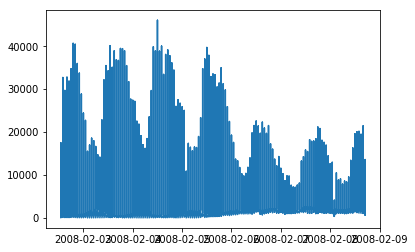

In [88]:
plt.plot(df.datetime,df.taxi_count)

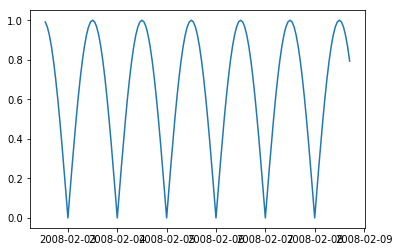

In [92]:
plt.plot(df.datetime,df.sin_frequency)